In [1]:
#### ALL NOTEBOOK SHOULD HAVE SOME VERSION OF THIS #####################################
########################################################################################
%load_ext autoreload
%autoreload 2
import os
import sys

currentdir = os.getcwd()
# go to root directory. change the # of os.path.dirnames based on where currentdir is
parentdir = os.path.dirname(currentdir)
# chek where I'm at. if I go too far up the tree, go back
if 'Protein-Purification-Model-Public' not in parentdir: parentdir = currentdir
if parentdir not in sys.path: sys.path.insert(0,parentdir)
########################################################################################

In [2]:
import utils
import visualization.simple_data_vis as vis
import surrogate_models.nn_defs as engine
import kerastuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# load data from just-private/data
filename = 'mol_res_scan_results_7.csv'
data = utils.load_data(parentdir, filename)

# since currently data is just one big dataframe, select model inputs as X and purity, yield as Y
x = [*data.columns[:2],*data.columns[4:]]
y = data.columns[2:4]

In [4]:
# split data into train and test
trains, tests = utils.data_pipeline([data,], x_data=x, y_data=y)

In [5]:
# define models to test out
dnn = engine.create_deterministic_nn(
    feature_names = x,
    target_names = y,
    hidden_units = [16,8,4],
    name = 'DNN_'+filename[:-4]
)

models = [dnn]

In [6]:
dnn.summary()

Model: "DNN_mol_res_scan_results_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 18)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           304         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            136         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4)            36          dense_1[0][0]                    
_________________________________________________________________________

In [7]:
# train all the models under the same conditions
learning_rate = 0.01
epochs = 100
optimizer = 'Adam' # change manually or come up with dictionary?
losses = ['mean_squared_error']
loss_weights = (1/trains[0][0][1].mean().div(trains[0][0][1].mean().max())).round(2).to_dict() # pretty much correcting for mean
histories = {}

for m,l in zip(models,losses):
    histories[utils.get_model_name(m,filename)] = engine.run_experiment(
        model = m, 
        loss = {y[0]:l,y[1]:l},
        loss_weights = loss_weights,
        optimizer = tf.keras.optimizers.Adam,
        learning_rate = learning_rate,
        num_epochs = epochs,
        train_dataset = trains[0][0], 
        test_dataset = tests[0][0],
        verbose = 0,
        log = 0
        )

settings = {'learning_rate' : learning_rate,
            'epochs' : epochs,
            'optimizer': optimizer,
            'loss_weights': loss_weights,
            'dataset' : filename}

Start training the model DNN_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.063
Test MSE: 0.06


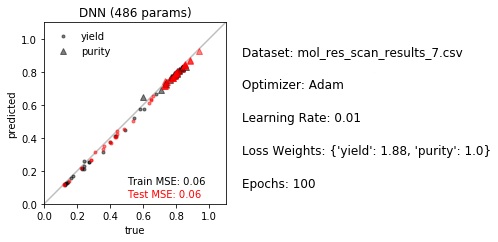

In [11]:
# check model predictions
vis.scatter_hats(models, trains[0][0], tests[0][0], settings, n_points = 25);

In [9]:
model_dir = utils.save_model(parentdir, dnn, settings)
saved_model, saved_settings = utils.load_model(model_dir)

INFO:tensorflow:Assets written to: c:\Users\dex36\Documents\GitHub\Protein-Purification-Model-Public\surrogate_models\saved_models\DNN_mol_res_scan_results_7\assets


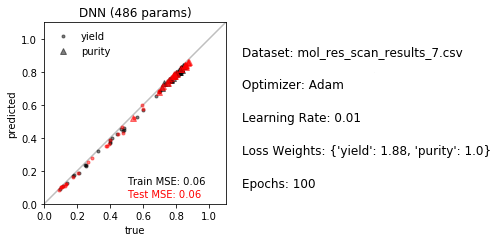

In [12]:
vis.scatter_hats([saved_model], trains[0][0], tests[0][0], saved_settings, n_points = 25);